# thal2 3:1 Bifurcation Diagrams

# Inits

## Imports

In [2]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import thal2 as t2

from lib.util import (get_phase, freq_est,follow_phase_diffs,follow_phase_diffs_del,
                        follow_phase_diffs_u,follow_phase_diffs_u_del,
get_smallest_eps,get_largest_eps, get_es_min, get_es_max,follow_phase_diffs_v2)

from lib.rhs import _redu_c2,_full, _redu_full, _full, _full_mono_rhs

from lib.plot_util import (add_diagram_1d_scatter, quick_plot_combined, 
                            draw_quick_plot_f, add_diagram_1d_del_scatter)


import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.signal import find_peaks
from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [3]:
kw_sim = {'rtol':1e-9,'atol':1e-9,'method':'LSODA'}

In [4]:
pd1 = {'gL':0.05,'gna':3,'gk':5,
       'gt':5,'eL':-70,'ena':50,
       'ek':-90,'et':0,'esyn':0,
       'c':1,'alpha':3,'beta':2,
       'sigmat':0.8,'vt':-20,
       'ib':8.5,'del':0,'om':1,'om_fix':1}

In [5]:
# default period must be 2*np.pi
kws1 = {'var_names':['v','h','r','w'],
        'pardict':pd1,
        'rhs':t2.rhs,
        'coupling':t2.coupling,
        'init':np.array([-.64,0.71,0.25,0,6]),
        'TN':20000,
        'trunc_order':1,
        'z_forward':False,
        'i_forward':[False,True,False,False,False,False],
        'i_bad_dx':[False,True,False,False,False,False],
        'max_iter':50,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
        'lc_prominence':.05,
        'factor':1}

## Defs

In [6]:
#### es_min,phi0 = get_es_min(data_bs_list,data_bu_list)
def get_monodromy_full(es_min,phi0,a,b,mname='',tol=1e-6,recompute=False,max_time=10000):
    """
    es_min: minimum epsilon to use
    a: nmCoupling object
    b: het. parameter.
    mnamei are the model names to save the monodromy matrix and related calculations
    """    

    kw_b = {'a':a,'b':b,'recompute':recompute,'bifdir':'bif1d_thal2/','_full_rhs':_full}
    print('es_min,phi0',es_min,phi0)
    # the _u function has the ability to save and load Y values
    _,Y = follow_phase_diffs(**dict(phi0=phi0,eps_init=es_min,eps_final=es_min-.01,deps=-1),max_time=max_time,tol=tol,return_point=True,**kw_b)

    print('Y',Y)
    # define parameters for finding monodromy of full system
    pd_vdp_thal = {**a.system1.pardict,**a.system2.pardict}
    pd_vdp_thal['b']=b
    pd_vdp_thal['a']=a
    
    pd_vdp_thal['eps']=es_min
    # print(pd1['del0'])
    
    # default period must be 2*np.pi
    kws_vdp_thal = {'var_names':['v0','h0','r0','w0','v1','h1','r1','w1'],
                    'pardict':pd_vdp_thal,
                    'rhs':_full_mono_rhs,
                    'coupling':lambda x: 0*x,
                    'init':Y, # from above
                    'use_init':True, # use init for direct LC calculation
                    'TN':50000,
                    'mode':'none', # forces not normalizing period.
                    'rtol_lc':1e-10,
                    'atol_lc':1e-10,
                    'trunc_order':0,
                    'z_forward':False,
                    'i_forward':False,
                    'i_bad_dx':[False,True,False,False,False,False],
                    'save_fig':False,
                    'max_iter':50,
                    'max_time_lc':5000,
                    'tol_root_lc':1e-8,
                    'halt_after_mono':True}

    m1 = rsp(idx='',model_name=mname,**kws_vdp_thal)

    return m1

In [7]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-9,'atol':1e-9}

In [8]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

In [9]:
ss,dss=np.linspace(0,2,100,retstep=True)

In [10]:
def compute_sol_all(a,eps,phi0,b,T=2000,dt=.01):
    """
    only for use in jupyter
    """
    t = np.arange(0,T,dt)
    args = {'args':(a,eps,b), 't_eval':t,**kw_sim}

    y0a = a.system1.lc['dat'][int((phi0/(2*np.pi)) * a.system1.TN),:]
    y0b = a.system2.lc['dat'][int((0/(2*np.pi)) * a.system2.TN),:]
    y0 = np.array([y0a,y0b]).flatten()
    #a.system1.pardict['del0'] = b

    tot = 0
    for i in range(len(a.het_coeffs)):
        tot += eps**i*b**(i+1)*a.het_coeffs[i]
    a.system1.pardict['del0'] = tot
    print(a.system1.pardict['del0'])
    #print(pd1['del0'])
    
    solf = solve_ivp(_full,[0,t[-1]], y0, **args)

    args['args'] = (a,eps,b,1)
    solr_o1 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    args['args'] = (a,eps,b,2)
    solr_o2 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,3)
    #solr_o3 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,4)
    #solr_o4 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)

    return solf, solr_o1, solr_o2#, solr_o3, solr_o4


def load_sol_all(a,eps,phi0,b,T,dt=.01,path_loc='sols_temp/',recompute=True):
    if (not os.path.exists(path_loc)):
        os.makedirs(path_loc)
    
    fname_f = 'sol_f_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)
    fname_r = 'sol_r_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)

    fname_f = path_loc + fname_f
    fname_r = path_loc + fname_r

    print('full',fname_f)
    print('redu',fname_r)
    
    file_dne = not(os.path.isfile(fname_f))
    file_dne += not(os.path.isfile(fname_r))

    if file_dne or recompute:
        solf, solr_o1, solr_o2 = compute_sol_all(a,eps,phi0,b,T=T,dt=dt)

        # phase of full model
        ta, pha = get_phase(solf.t,solf.y.T[:,:4], skipn=200,system1=a.system1)
        tb, phb = get_phase(solf.t,solf.y.T[:,4:], skipn=200,system1=a.system2)

        dat1 = np.zeros([len(ta),2])
        dat1[:,0] = ta
        dat1[:,1] = np.mod(pha - a.om*phb,2*np.pi)

        dat2 = np.zeros([len(solr_o1.t),5])
        dat2[:,0] = solr_o1.t
        dat2[:,1] = solr_o1.y[0]
        dat2[:,2] = solr_o2.y[0]

        np.savetxt(fname_f,dat1)
        np.savetxt(fname_r,dat2)

    else:
        dat1 = np.loadtxt(fname_f)
        dat2 = np.loadtxt(fname_r)
    return dat1, dat2

## Initialize Response Functions

In [11]:
system1 = rsp(idx=0,model_name='thal0_85',**kws1)
system2 = rsp(idx=1,model_name='thal1_85',**kws1)

mkdir ./data/thal0_85/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.024354475778909167
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/thal1_85/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.024354475778909167
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


# Initialize Coupling 3:1

In [12]:
het_coeffs = [1,100]

In [13]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
nm_tup = (3,1)
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',nm_tup[0]),'_m':('om1',nm_tup[1]),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':het_coeffs, # [eps, eps^2, etc]
        }
a = nm.nmCoupling(**kw_nm)
nm_val = str(nm_tup[0])+str(nm_tup[1])

Initializing 31 Coupling...
pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_85, order=0...
* Loading H thal1_85, order=0...
* Loading H thal0_85, order=1...
* Loading H thal1_85, order=1...


### Plot 1par eps

<Axes: >

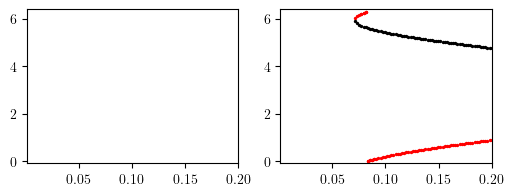

In [14]:
etup = (.001,.2,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,b=-.04,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

### Plot 1par del

<Axes: >

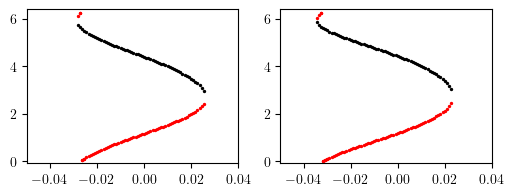

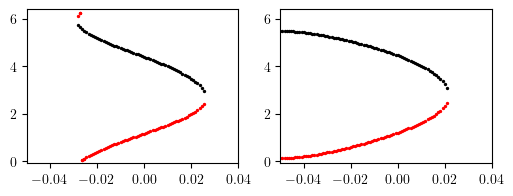

In [15]:
dtup12 = (-.05,.04,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,eps=0.05,del_tup=dtup12,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,eps=0.1,del_tup=dtup12,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

#for i in range(4):
#    draw_quick_plot_f(axs[i],data_b1_list,a)

## EPS VARY

In [16]:
kw_b = {'a':a,'b':0,'recompute':False,'bifdir':'bif1d_thal2/','_full_rhs':_full}
fname_bs = kw_b['bifdir']+'hyper_thal2_'+nm_val+'_b={}_s.txt'
fname_bu = kw_b['bifdir']+'hyper_thal2_'+nm_val+'_b={}_u.txt'

In [17]:
mname_list = ['thal2_'+nm_val+'_b'+str(i)+'={}' for i in range(5)]

In [18]:
b_vals_full = []
e_vals_full = [] # save min eps values for all diagrams
e_hi_full = [] # save max eps values for all diagrams

## monodromy calculations
e_vals_mono_min = [] # save eps values at min monodromy
eigenvalues_min_all = []
b_min_all = []

e_vals_mono_max = [] # save eps values at max monodromy
eigenvalues_max_all = []
b_max_all = []

### b=0.025

#### Branches eps stable

In [19]:
b=0.025
kw_b['recompute'] = False
kw_b['b'] = b

In [20]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=4,eps_init=0.002,eps_final=0,deps=-.0001),
            dict(phi0=4,eps_init=0.0019,eps_final=0.2,deps=.001)]

In [21]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 4
phi init 4


In [22]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [23]:
kw_b['recompute'] = False
kw_b['b'] = b

In [24]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,2,20)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.1,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

In [25]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=2.1,eps_init=0.002,eps_final=0,deps=-2),tol=1e-6,max_iter=100,return_point=True,**kw_b)

phi init 2.1
phase_diffs_u_init=2.1_nm=31_b=0.025_ei=0.002_ef=0_de=-2.txt
phase_diffs_u_pt_init=2.1_nm=31_b=0.025_ei=0.002_ef=0_de=-2.txt


In [26]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2.1,eps_init=0.002,eps_final=0,deps=-.0001),
            dict(phi0=2.1,eps_init=0.0019,eps_final=0.2,deps=.001),
           ]

In [27]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2.1
phase_diffs_u_init=2.1_nm=31_b=0.025_ei=0.002_ef=0_de=-0.0001.txt
phase_diffs_u_pt_init=2.1_nm=31_b=0.025_ei=0.002_ef=0_de=-0.0001.txt
phi init 2.1
phase_diffs_u_init=2.1_nm=31_b=0.025_ei=0.0019_ef=0.2_de=0.001.txt
phase_diffs_u_pt_init=2.1_nm=31_b=0.025_ei=0.0019_ef=0.2_de=0.001.txt


In [28]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

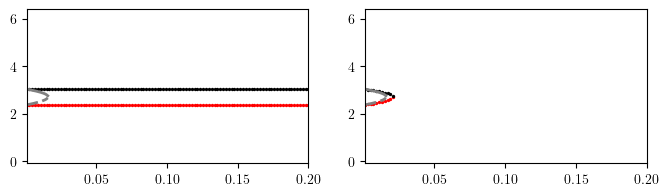

In [29]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys max

In [30]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.015899999999999997 2.7501982200030355
phi init 2.7501982200030355
Y [-1.07382022e-01  2.41373951e-01  9.36761445e-02  3.88667416e-01 -4.31084155e-01  6.58739030e-01  9.51348575e-02  2.36237999e-05  6.26088127e+00]
mkdir ./data/thal2_31_b0=0.025/
* Loading LC data...
self.T 6.260881309805955
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00029586691330410724
es_min,phi0 0.015399999999999997 2.7501982200030355
phi init 2.7501982200030355
Y [-1.07445007e-01  2.26821666e-01  9.35370498e-02  4.05273676e-01 -5.82059274e-01  5.40054422e-01  9.80982705e-02  1.52194658e-03  6.26151028e+00]
mkdir ./data/thal2_31_b1=0.025/
* Loading LC data...
self.T 6.261510316770045
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00047638120096206833
es_min,phi0 0.014899999999999997 2.7501982200030355
phi init 2.7501982200030355
Y [-1.07737359e-01  2.17566472e-01  9.35329465e-02  4.15953369e-01 -5.82220230e-01  5.39793555e-01  9.8149

In [31]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=0.02

#### Branches eps stable

In [32]:
b=0.02
kw_b['recompute'] =False
kw_b['b'] = b

In [33]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=4,eps_init=0.002,eps_final=0,deps=-.0001),
            dict(phi0=4,eps_init=0.0019,eps_final=0.2,deps=.01)]

In [34]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 4
phi init 4


In [35]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [36]:
kw_b['recompute'] = False
kw_b['b'] = b

In [37]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,2,20)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.1,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

In [38]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=2,eps_init=0.002,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 2
phase_diffs_u_init=2_nm=31_b=0.02_ei=0.002_ef=0_de=-2.txt
phase_diffs_u_pt_init=2_nm=31_b=0.02_ei=0.002_ef=0_de=-2.txt


In [39]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2,eps_init=0.002,eps_final=0,deps=-.0001),
            dict(phi0=2,eps_init=0.0019,eps_final=0.2,deps=.01),
           ]

In [40]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2
phase_diffs_u_init=2_nm=31_b=0.02_ei=0.002_ef=0_de=-0.0001.txt
phase_diffs_u_pt_init=2_nm=31_b=0.02_ei=0.002_ef=0_de=-0.0001.txt
phi init 2
phase_diffs_u_init=2_nm=31_b=0.02_ei=0.0019_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=2_nm=31_b=0.02_ei=0.0019_ef=0.2_de=0.01.txt


In [41]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

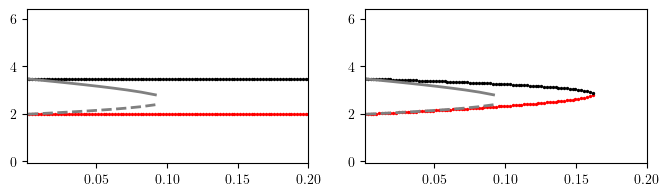

In [42]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys max

In [43]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.0919 2.789942389685777
phi init 2.789942389685777
Y [-0.12253034  0.21426365  0.09273707  0.40427295 -0.53416369  0.12879918  0.08433754  0.12445931  6.15903531]
mkdir ./data/thal2_31_b0=0.02/
* Loading LC data...
self.T 6.15903532063023
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.008697379810968015
es_min,phi0 0.0914 2.789942389685777
phi init 2.789942389685777
Y [-1.05308200e-01  2.30948347e-01  9.29232422e-02  4.03230843e-01 -4.34191871e-01  6.49044380e-01  8.95507497e-02  2.89489526e-05  6.15957337e+00]
mkdir ./data/thal2_31_b1=0.02/
* Loading LC data...
self.T 6.159573389012532
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.008882080199093438
es_min,phi0 0.0909 2.789942389685777
phi init 2.789942389685777
Y [-1.05319067e-01  2.28670381e-01  9.29468096e-02  4.05827341e-01 -4.34315732e-01  6.49111810e-01  8.95960172e-02  2.89945249e-05  6.16011537e+00]
mkdir ./data/thal2_31_b2=0.02/
* Loading LC data.

In [44]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=0.018

#### Branches eps stable

In [45]:
b=0.018
kw_b['recompute'] = False
kw_b['b'] = b

In [46]:
_,Yinit = follow_phase_diffs(**dict(phi0=4,eps_init=0.1,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 4


In [47]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=4.01,eps_init=0.1,eps_final=0,deps=-.01),
    dict(phi0=4.01,eps_init=0.099,eps_final=0.2,deps=.01)
]

In [48]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(use_point=Yinit,**in1,**kw_b)
    data_bs_list.append(dat)

phi init 4.01
phi init 4.01


In [49]:
# # data_bs_list = []
# in_dicts = [
#     dict(phi0=2,eps_init=0.1,eps_final=0,deps=-.01),
#     dict(phi0=2,eps_init=0.099,eps_final=.2,deps=.01),
#     dict(phi0=2,eps_init=0.13,eps_final=.2,deps=.001),
# ]

# eps_list = []
# tsx_list = []
# tsy_list = []
# tdiffs_list = []
# for i in range(len(in_dicts)):
#     in1 = in_dicts[i]
#     eps_range,tsx,tsy,tdiffs = follow_phase_diffs_v2(tol=1e-6,**in1,**kw_b)
#     # try first index
#     eps_list.append(eps_range)
#     tsx_list.append(tsx)
#     tsy_list.append(tsy)
#     tdiffs_list.append(tdiffs)
#     #dat = np.zeros([len(eps_range),2]) 
#     print(tdiffs)
#     #dat[:,0] = eps_range
#     #dat[:,1] = np.mod(-2*np.pi*np.mean(tdiffs[:,::a._n[1]],axis=1)/np.mean(tsx,axis=1),2*np.pi)
#     # print()

In [50]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [51]:
kw_b['recompute'] = False
kw_b['b'] = b

In [52]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,2,20)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.1,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

In [53]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=2,eps_init=0.1,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 2
phase_diffs_u_init=2_nm=31_b=0.018_ei=0.1_ef=0_de=-2.txt
phase_diffs_u_pt_init=2_nm=31_b=0.018_ei=0.1_ef=0_de=-2.txt


In [54]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2,eps_init=0.1,eps_final=0,deps=-.01),
            dict(phi0=2,eps_init=0.099,eps_final=0.2,deps=.01),
           ]

In [55]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2
phase_diffs_u_init=2_nm=31_b=0.018_ei=0.1_ef=0_de=-0.01.txt
phase_diffs_u_pt_init=2_nm=31_b=0.018_ei=0.1_ef=0_de=-0.01.txt
phi init 2
phase_diffs_u_init=2_nm=31_b=0.018_ei=0.099_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=2_nm=31_b=0.018_ei=0.099_ef=0.2_de=0.01.txt


In [56]:
# # data_bs_list = []
# in_dicts = [
#     dict(phi0=2.02,eps_init=0.1,eps_final=0,deps=-.01),
#     dict(phi0=2.02,eps_init=0.099,eps_final=.2,deps=.01),
#     dict(phi0=2.02,eps_init=0.13,eps_final=.2,deps=.001),
# ]

# eps_list_u = []
# tsx_list_u = []
# tsy_list_u = []
# tdiffs_list_u = []
# for i in range(len(in_dicts)):
#     in1 = in_dicts[i]
#     eps_range,tsx,tsy,tdiffs = follow_phase_diffs_v2(use_point=Yinit,tol=1e-6,**in1,**kw_b)
#     # try first index
#     eps_list_u.append(eps_range)
#     tsx_list_u.append(tsx)
#     tsy_list_u.append(tsy)
#     tdiffs_list_u.append(tdiffs)
#     #dat = np.zeros([len(eps_range),2]) 
#     print(tdiffs)
#     #dat[:,0] = eps_range
#     #dat[:,1] = np.mod(-2*np.pi*np.mean(tdiffs[:,::a._n[1]],axis=1)/np.mean(tsx,axis=1),2*np.pi)
#     # print()

In [57]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

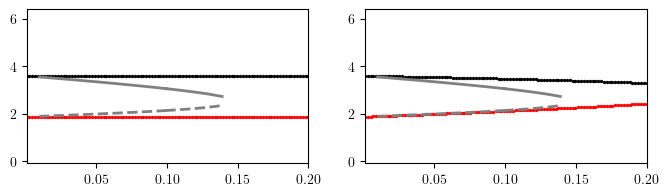

In [58]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [59]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
# # add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

# data_bs_list = []

# T1 = np.sum(tsx_list[0],axis=1)
# axs[1].plot(eps_list[0],np.mod(-a._n[1]*2*np.pi*(tdiffs_list[0][:,0])/T1,2*np.pi),color='gray')
# T2 = np.sum(tsx_list[1],axis=1)
# axs[1].plot(eps_list[1],np.mod(-a._n[1]*2*np.pi*(tdiffs_list[1][:,0])/T2,2*np.pi),color='gray')
# T3 = np.sum(tsx_list[2],axis=1)
# axs[1].plot(eps_list[2],np.mod(-a._n[1]*2*np.pi*(tdiffs_list[2][:,0])/T3,2*np.pi),color='gray')
# #axs[1].plot(eps_list[2],np.mod(tdiffs_list[2][:,0]/np.sum(tsx_list[2],axis=1),1))


# T1 = np.sum(tsx_list_u[0],axis=1)
# axs[1].plot(eps_list_u[0],np.mod(-a._n[1]*2*np.pi*(tdiffs_list_u[0][:,0])/T1,2*np.pi),ls='--',color='gray')
# T2 = np.sum(tsx_list_u[1],axis=1)
# axs[1].plot(eps_list_u[1],np.mod(-a._n[1]*2*np.pi*(tdiffs_list_u[1][:,0])/T2,2*np.pi),ls='--',color='gray')
# T3 = np.sum(tsx_list_u[2],axis=1)
# axs[1].plot(eps_list_u[2],np.mod(-a._n[1]*2*np.pi*(tdiffs_list_u[2][:,0])/T3,2*np.pi),ls='--',color='gray')
# #axs[1].plot(eps_list[2],np.mod(tdiffs_list[2][:,0]/np.sum(tsx_list[2],axis=1),1))

# # T = np.sum(tsx_list[0][0,:])
# # axs[1].plot(eps_list[0],3*tdiffs_list[0][:,1]/T)
# # axs[1].plot(eps_list[1],3*tdiffs_list[1][:,1]/T)

# # axs[1].plot(eps_list[0],6*tdiffs_list[0][:,2]/T)
# # axs[1].plot(eps_list[1],6*tdiffs_list[1][:,2]/T)

# for i in range(2):
#     pass
#     # draw_quick_plot_f(axs[i],data_bs_list,a)
#     # draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

# # axs[1].set_ylim(.2,.6)

#### Monodromys max

In [60]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.13899999999999998 2.72121695005762
phi init 2.72121695005762
Y [-1.08751085e-01  2.33741728e-01  9.07374965e-02  3.96484844e-01 -5.88272052e-01  5.13842897e-01  8.91265117e-02  2.07324583e-03  6.10127166e+00]
mkdir ./data/thal2_31_b0=0.018/
* Loading LC data...
self.T 6.101271682774782
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.012601797777941577
es_min,phi0 0.13849999999999998 2.72121695005762
phi init 2.72121695005762
Y [-1.08723710e-01  2.32356285e-01  9.07897215e-02  3.98117906e-01 -5.88320353e-01  5.13763322e-01  8.91654167e-02  2.07703805e-03  6.10172291e+00]
mkdir ./data/thal2_31_b1=0.018/
* Loading LC data...
self.T 6.101722924665662
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.012912454789730082
es_min,phi0 0.13799999999999998 2.72121695005762
phi init 2.72121695005762
Y [-0.12969825  0.23449245  0.09169365  0.36764148 -0.51904682  0.12039947  0.08186134  0.13810255  6.10217933]
mkdir ./data/

In [61]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=0.015

#### Branches eps stable

In [62]:
b=0.015
kw_b['recompute'] = False
kw_b['b'] = b

In [63]:
_,Yinit = follow_phase_diffs(**dict(phi0=4,eps_init=0.1,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 4


In [64]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=4.01,eps_init=0.1,eps_final=0,deps=-.01),
    dict(phi0=4.01,eps_init=0.099,eps_final=0.2,deps=.01)
]

In [65]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(use_point=Yinit,**in1,**kw_b)
    data_bs_list.append(dat)

phi init 4.01
phi init 4.01


In [66]:
data_bs_list

[array([[0.1       , 2.04634158, 3.34127492],
        [0.09      , 2.05080826, 3.38546897],
        [0.08      , 2.05527494, 3.42763666],
        [0.07      , 2.05994163, 3.47050466],
        [0.06      , 2.06460832, 3.51196156],
        [0.05      , 2.06940834, 3.55360978],
        [0.04      , 2.07427502, 3.59434387],
        [0.03      , 2.07920837, 3.63477072],
        [0.02      , 2.08420839, 3.67488863],
        [0.01      , 2.08920841, 3.71361153]]),
 array([[0.099     , 2.04680824, 3.34603869],
        [0.109     , 2.04240823, 3.30156408],
        [0.119     , 2.03814154, 3.2560678 ],
        [0.129     , 2.03400819, 3.21017019],
        [0.139     , 2.02987484, 3.16284752],
        [0.149     , 2.02594149, 3.11440391],
        [0.159     , 2.02214148, 3.06494823],
        [0.169     , 2.01840813, 3.01333897],
        [0.179     , 2.01480812, 2.95947134],
        [0.189     , 2.01134143, 2.90209437],
        [0.199     , 2.00807475, 2.841107  ]])]

In [67]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [68]:
kw_b['recompute'] = False
kw_b['b'] = b

In [69]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,2,20)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.1,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

In [70]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=1.9,eps_init=0.1,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 1.9
phase_diffs_u_init=1.9_nm=31_b=0.015_ei=0.1_ef=0_de=-2.txt
phase_diffs_u_pt_init=1.9_nm=31_b=0.015_ei=0.1_ef=0_de=-2.txt


In [71]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=1.9,eps_init=0.1,eps_final=0,deps=-.01),
            dict(phi0=1.9,eps_init=0.099,eps_final=0.2,deps=.01),
           ]

In [72]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 1.9
phase_diffs_u_init=1.9_nm=31_b=0.015_ei=0.1_ef=0_de=-0.01.txt
phase_diffs_u_pt_init=1.9_nm=31_b=0.015_ei=0.1_ef=0_de=-0.01.txt
phi init 1.9
phase_diffs_u_init=1.9_nm=31_b=0.015_ei=0.099_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=1.9_nm=31_b=0.015_ei=0.099_ef=0.2_de=0.01.txt


In [73]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

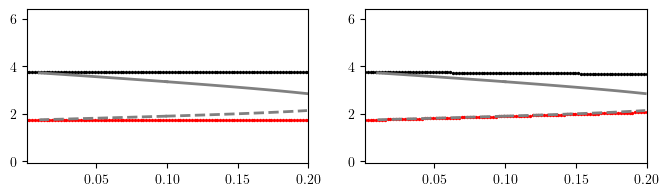

In [74]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [75]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.028

#### Sim

In [76]:
# a=a;T=5000;b=0.007;e=.038;phi0 = 4
# dat1,dat2=load_sol_all(a=a,eps=e,phi0=phi0,b=b,T=T,recompute=False)
# t1=dat1[:,0];y=dat1[:,1]
# t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]

# fig,axs = plt.subplots(figsize=(4,2))

# axs.scatter(t1,y,s=1,alpha=.5,color='black')

# axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
# axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

# axs.set_ylim(-.5,2*np.pi+.5)
# axs.legend()

##### Original

In [77]:
# # show original system
# a=a;T=1000;b=0.007;e=.02;phi0 = 4
# solf, solr_o1, solr_o2 = compute_sol_all(a,e,phi0,b,T=T,dt=.01)

In [78]:
# fig,axs = plt.subplots(figsize=(4,2))
# axs.plot(solf.t,solf.y[0])
# # axs.plot(solf.t,solf.y[3])
# axs.plot(solf.t,solf.y[4])
# axs.set_xlim(800,1000)

#### Branches eps stable

In [79]:
b=-.028
kw_b['recompute'] = False
kw_b['b'] = b

In [80]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=1,eps_init=0.05,eps_final=0,deps=-.005),
            dict(phi0=1,eps_init=0.049,eps_final=0.2,deps=.005)]

In [81]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [82]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [83]:
kw_b['recompute'] = False
kw_b['b'] = b

In [84]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,2,20)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.1,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

In [85]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=6.2,eps_init=0.01,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 6.2
phase_diffs_u_init=6.2_nm=31_b=-0.028_ei=0.01_ef=0_de=-2.txt
phase_diffs_u_pt_init=6.2_nm=31_b=-0.028_ei=0.01_ef=0_de=-2.txt


In [86]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=0,eps_init=0.01,eps_final=0,deps=-.001),
            dict(phi0=6.255,eps_init=0.0099,eps_final=0.2,deps=.01),
           ]

In [87]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 0
phase_diffs_u_init=0_nm=31_b=-0.028_ei=0.01_ef=0_de=-0.001.txt
phase_diffs_u_pt_init=0_nm=31_b=-0.028_ei=0.01_ef=0_de=-0.001.txt
phi init 6.255
phase_diffs_u_init=6.255_nm=31_b=-0.028_ei=0.0099_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=6.255_nm=31_b=-0.028_ei=0.0099_ef=0.2_de=0.01.txt


In [88]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

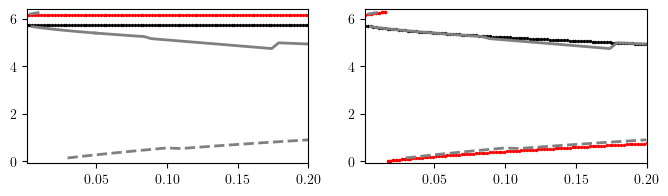

In [89]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [90]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.04

#### Branches eps stable

In [91]:
b=-.04
kw_b['recompute'] = False
kw_b['b'] = b

In [92]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=5,eps_init=0.15,eps_final=0,deps=-.005),
            dict(phi0=5,eps_init=0.149,eps_final=0.2,deps=.005)]

In [93]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 5
phi init 5


In [94]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [95]:
kw_b['recompute'] = False
kw_b['b'] = b

In [96]:
kw_b['b'] = 0
da,Yinit = follow_phase_diffs_u(**dict(phi0=1,eps_init=0.1,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.01
da,Yinit = follow_phase_diffs_u(**dict(phi0=1,eps_init=0.1,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.02
da,Yinit = follow_phase_diffs_u(**dict(phi0=1,eps_init=0.1,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.03
da,Yinit = follow_phase_diffs_u(**dict(phi0=1,eps_init=0.1,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.035
da,Yinit = follow_phase_diffs_u(**dict(phi0=1,eps_init=0.1,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.04
da,Yinit = follow_phase_diffs_u(**dict(phi0=1,eps_init=0.0999,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 1
phase_diffs_u_init=1_nm=31_b=0_ei=0.1_ef=0_de=-2.txt
phase_diffs_u_pt_init=1_nm=31_b=0_ei=0.1_ef=0_de=-2.txt
[0.1        2.0531416  1.24064194]
phi init 1
phase_diffs_u_init=1_nm=31_b=-0.01_ei=0.1_ef=0_de=-2.txt
phase_diffs_u_pt_init=1_nm=31_b=-0.01_ei=0.1_ef=0_de=-2.txt
[0.1        2.0515416  0.93227908]
phi init 1
phase_diffs_u_init=1_nm=31_b=-0.02_ei=0.1_ef=0_de=-2.txt
phase_diffs_u_pt_init=1_nm=31_b=-0.02_ei=0.1_ef=0_de=-2.txt
[0.1        2.04980826 0.66638915]
phi init 1
phase_diffs_u_init=1_nm=31_b=-0.03_ei=0.1_ef=0_de=-2.txt
phase_diffs_u_pt_init=1_nm=31_b=-0.03_ei=0.1_ef=0_de=-2.txt
[0.1        2.04820825 0.44419746]
phi init 1
phase_diffs_u_init=1_nm=31_b=-0.035_ei=0.1_ef=0_de=-2.txt
phase_diffs_u_pt_init=1_nm=31_b=-0.035_ei=0.1_ef=0_de=-2.txt
[0.1        2.04767491 0.35655517]
phi init 1
phase_diffs_u_init=1_nm=31_b=-0.04_ei=0.0999_ef=0_de=-2.txt
phase_diffs_u_pt_init=1_nm=31_b=-0.04_ei=0.0999_ef=0_de=-2.txt
[0.0999     2.04727491 0.28726406]


In [97]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=.5,eps_init=0.100001,eps_final=0,deps=-.001),
            dict(phi0=.5,eps_init=0.09999,eps_final=0.2,deps=.005),
           ]

In [98]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 0.5
phase_diffs_u_init=0.5_nm=31_b=-0.04_ei=0.100001_ef=0_de=-0.001.txt
phase_diffs_u_pt_init=0.5_nm=31_b=-0.04_ei=0.100001_ef=0_de=-0.001.txt
phi init 0.5
phase_diffs_u_init=0.5_nm=31_b=-0.04_ei=0.09999_ef=0.2_de=0.005.txt
phase_diffs_u_pt_init=0.5_nm=31_b=-0.04_ei=0.09999_ef=0.2_de=0.005.txt


In [99]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

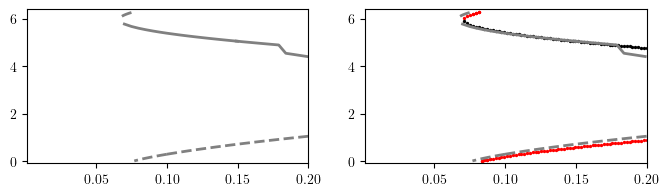

In [100]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [101]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.06700099999999998 6.039209693388026
phi init 6.039209693388026
Y [-1.10117622e-01  2.32506151e-01  8.57580373e-02  3.95060374e-01 -5.15166215e-01  6.19517367e-01  9.41753636e-02  2.09401592e-04  6.17963908e+00]
mkdir ./data/thal2_31_b0=-0.04/
* Loading LC data...
self.T 6.17964096036998
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.003085897071001015
es_min,phi0 0.06750099999999998 6.039209693388026
phi init 6.039209693388026
Y [-0.10780855  0.21709004  0.08647567  0.41474635 -0.14140431  0.13558775  0.08882676  0.50271693  6.17872097]
mkdir ./data/thal2_31_b1=-0.04/
* Loading LC data...
self.T 6.178722758397717
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.004084593023186387
es_min,phi0 0.06800099999999998 6.039209693388026
phi init 6.039209693388026
Y [-0.10785619  0.21567986  0.08650089  0.41638394 -0.14421805  0.13229266  0.08879632  0.50616242  6.1778391 ]
mkdir ./data/thal2_31_b2=-0.04/
* Loading LC

In [102]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.06

#### Branches eps stable

In [103]:
b=-.06
kw_b['recompute'] = False
kw_b['b'] = b

In [104]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=5,eps_init=0.15,eps_final=0,deps=-.002),
            dict(phi0=5,eps_init=0.149,eps_final=0.2,deps=.005)]

In [105]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 5
phi init 5


In [106]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

In [107]:
# data_bs_list = []
in_dicts = [
    dict(phi0=2.02,eps_init=0.1,eps_final=0,deps=-.01),
    dict(phi0=2.02,eps_init=0.099,eps_final=.2,deps=.01),
    dict(phi0=2.02,eps_init=0.13,eps_final=.2,deps=.001),
]

eps_list_u = []
tsx_list_u = []
tsy_list_u = []
tdiffs_list_u = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    eps_range,tsx,tsy,tdiffs = follow_phase_diffs_v2(use_point=Yinit,tol=1e-6,**in1,**kw_b)
    # try first index
    eps_list_u.append(eps_range)
    tsx_list_u.append(tsx)
    tsy_list_u.append(tsy)
    tdiffs_list_u.append(tdiffs)
    #dat = np.zeros([len(eps_range),2]) 
    print(tdiffs)
    #dat[:,0] = eps_range
    #dat[:,1] = np.mod(-2*np.pi*np.mean(tdiffs[:,::a._n[1]],axis=1)/np.mean(tsx,axis=1),2*np.pi)
    # print()

phi init 2.02
[[12.1893595  10.12329856  8.06323781]
 [12.29236253 10.22830166  8.1682409 ]
 [        nan         nan         nan]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
phi init 2.02
[[12.19835976 10.13229883  8.07223807]
 [12.11535731 10.04729632  7.98723556]
 [12.04435522  9.97329414  7.91223335]
 [11.97835327  9.90329207  7.84023123]
 [11.91635144  9.83829016  7.77122919]
 [11.85934976  9.7752883   7.70522725]
 [11.80334811  9.71228644  7.63822527]
 [11.74634643  9.64828455  7.56922324]
 [11.68934475  9.58428266  7.49822114]
 [11.63134304  9.51628066  7.42421896]
 [11.56634112  9.44127845  7.34121651]]
phi init 2.02
[[11.9723531   9.89829193  7.83423105]
 [11.96535289  9.89029169  7.82623082]
 [11.96035274  9.88429151  7.82023064]
 [11.95335253  9.877

In [108]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
# # add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

# data_bs_list = []

# T1 = np.sum(tsx_list[0],axis=1)
# axs[1].plot(eps_list[0],np.mod(-a._n[1]*2*np.pi*(tdiffs_list[0][:,0])/T1,2*np.pi),color='gray')
# T2 = np.sum(tsx_list[1],axis=1)
# axs[1].plot(eps_list[1],np.mod(-a._n[1]*2*np.pi*(tdiffs_list[1][:,0])/T2,2*np.pi),color='gray')
# T3 = np.sum(tsx_list[2],axis=1)
# axs[1].plot(eps_list[2],np.mod(-a._n[1]*2*np.pi*(tdiffs_list[2][:,0])/T3,2*np.pi),color='gray')
# #axs[1].plot(eps_list[2],np.mod(tdiffs_list[2][:,0]/np.sum(tsx_list[2],axis=1),1))


# T1 = np.sum(tsx_list_u[0],axis=1)
# axs[1].plot(eps_list_u[0],np.mod(-a._n[1]*2*np.pi*(tdiffs_list_u[0][:,0])/T1,2*np.pi),ls='--',color='gray')
# T2 = np.sum(tsx_list_u[1],axis=1)
# axs[1].plot(eps_list_u[1],np.mod(-a._n[1]*2*np.pi*(tdiffs_list_u[1][:,0])/T2,2*np.pi),ls='--',color='gray')
# T3 = np.sum(tsx_list_u[2],axis=1)
# axs[1].plot(eps_list_u[2],np.mod(-a._n[1]*2*np.pi*(tdiffs_list_u[2][:,0])/T3,2*np.pi),ls='--',color='gray')
# #axs[1].plot(eps_list[2],np.mod(tdiffs_list[2][:,0]/np.sum(tsx_list[2],axis=1),1))

# # T = np.sum(tsx_list[0][0,:])
# # axs[1].plot(eps_list[0],3*tdiffs_list[0][:,1]/T)
# # axs[1].plot(eps_list[1],3*tdiffs_list[1][:,1]/T)

# # axs[1].plot(eps_list[0],6*tdiffs_list[0][:,2]/T)
# # axs[1].plot(eps_list[1],6*tdiffs_list[1][:,2]/T)

# for i in range(2):
#     pass
#     # draw_quick_plot_f(axs[i],data_bs_list,a)
#     # draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

# # axs[1].set_ylim(.2,.6)

#### Branches eps unstable

In [109]:
kw_b['recompute'] = False
kw_b['b'] = b

In [110]:
kw_b['b'] = -.04
da,Yinit = follow_phase_diffs_u(**dict(phi0=1,eps_init=0.0999,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.045
da,Yinit = follow_phase_diffs_u(**dict(phi0=1,eps_init=0.12,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.05
da,Yinit = follow_phase_diffs_u(**dict(phi0=1,eps_init=0.13,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.055
da,Yinit = follow_phase_diffs_u(**dict(phi0=1,eps_init=0.13,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.06
da,Yinit = follow_phase_diffs_u(**dict(phi0=1,eps_init=0.14,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 1
phase_diffs_u_init=1_nm=31_b=-0.04_ei=0.0999_ef=0_de=-2.txt
phase_diffs_u_pt_init=1_nm=31_b=-0.04_ei=0.0999_ef=0_de=-2.txt
[0.0999     2.04727491 0.28726406]
phi init 1
phase_diffs_u_init=1_nm=31_b=-0.045_ei=0.12_ef=0_de=-2.txt
phase_diffs_u_pt_init=1_nm=31_b=-0.045_ei=0.12_ef=0_de=-2.txt
[0.12       2.04000822 0.47801488]
phi init 1
phase_diffs_u_init=1_nm=31_b=-0.05_ei=0.13_ef=0_de=-2.txt
phase_diffs_u_pt_init=1_nm=31_b=-0.05_ei=0.13_ef=0_de=-2.txt
[0.13       2.03727487 0.631012  ]
phi init 1
phase_diffs_u_init=1_nm=31_b=-0.055_ei=0.13_ef=0_de=-2.txt
phase_diffs_u_pt_init=1_nm=31_b=-0.055_ei=0.13_ef=0_de=-2.txt
[0.13       2.03794154 0.70665024]
phi init 1
phase_diffs_u_init=1_nm=31_b=-0.06_ei=0.14_ef=0_de=-2.txt
phase_diffs_u_pt_init=1_nm=31_b=-0.06_ei=0.14_ef=0_de=-2.txt
[0.14       2.0362082  0.94423667]


In [111]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=1,eps_init=0.14,eps_final=0,deps=-.001),
            dict(phi0=1,eps_init=0.1399,eps_final=0.2,deps=.01),
           ]

In [112]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 1
phase_diffs_u_init=1_nm=31_b=-0.06_ei=0.14_ef=0_de=-0.001.txt
phase_diffs_u_pt_init=1_nm=31_b=-0.06_ei=0.14_ef=0_de=-0.001.txt
phi init 1
phase_diffs_u_init=1_nm=31_b=-0.06_ei=0.1399_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=1_nm=31_b=-0.06_ei=0.1399_ef=0.2_de=0.01.txt


In [113]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

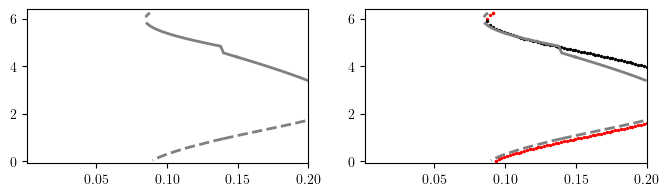

In [114]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [115]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.08499999999999996 6.057167040621844
phi init 6.057167040621844
Y [-1.10776605e-01  2.25800884e-01  8.37763827e-02  4.02136090e-01 -5.14915351e-01  6.17193475e-01  9.29256823e-02  2.14730166e-04  6.15304746e+00]
mkdir ./data/thal2_31_b0=-0.06/
* Loading LC data...
self.T 6.150898636313922
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00815430384207382
es_min,phi0 0.08549999999999996 6.057167040621844
phi init 6.057167040621844
Y [-0.10764341  0.22152166  0.08481755  0.40915006 -0.14447164  0.13310981  0.08768887  0.50489782  6.15191696]
mkdir ./data/thal2_31_b1=-0.06/
* Loading LC data...
self.T 6.14993372224349
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00949549641684583
es_min,phi0 0.08599999999999997 6.057167040621844
phi init 6.057167040621844
Y [-0.11817321  0.23359525  0.08360873  0.38387005 -0.6259203   0.37774077  0.09021158  0.01214512  6.15089864]
mkdir ./data/thal2_31_b2=-0.06/
* Loading LC d

In [116]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.08

#### Branches eps stable

In [117]:
b=-.08
kw_b['recompute'] = False
kw_b['b'] = b

In [118]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=5,eps_init=0.1,eps_final=0,deps=-.002),
            dict(phi0=5,eps_init=0.099,eps_final=0.2,deps=.005)]

In [119]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 5
phi init 5


In [120]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [121]:
kw_b['recompute'] = False
kw_b['b'] = b

In [122]:
kw_b['b'] = -.06
da,Yinit = follow_phase_diffs_u(**dict(phi0=1,eps_init=0.14,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.07
da,Yinit = follow_phase_diffs_u(**dict(phi0=1,eps_init=0.14,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = b
da,Yinit = follow_phase_diffs_u(**dict(phi0=1,eps_init=0.14,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 1
phase_diffs_u_init=1_nm=31_b=-0.06_ei=0.14_ef=0_de=-2.txt
phase_diffs_u_pt_init=1_nm=31_b=-0.06_ei=0.14_ef=0_de=-2.txt
[0.14       2.0362082  0.94423667]
phi init 1
phase_diffs_u_init=1_nm=31_b=-0.07_ei=0.14_ef=0_de=-2.txt
phase_diffs_u_pt_init=1_nm=31_b=-0.07_ei=0.14_ef=0_de=-2.txt
[0.14       2.03827488 1.22379697]
phi init 1
phase_diffs_u_init=1_nm=31_b=-0.08_ei=0.14_ef=0_de=-2.txt
phase_diffs_u_pt_init=1_nm=31_b=-0.08_ei=0.14_ef=0_de=-2.txt
[0.14       2.03937184 1.59595782]


In [123]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=1,eps_init=0.14,eps_final=0,deps=-.001),
            dict(phi0=1,eps_init=0.1399,eps_final=0.2,deps=.01),
           ]

In [124]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 1
phase_diffs_u_init=1_nm=31_b=-0.08_ei=0.14_ef=0_de=-0.001.txt
phase_diffs_u_pt_init=1_nm=31_b=-0.08_ei=0.14_ef=0_de=-0.001.txt
phi init 1
phase_diffs_u_init=1_nm=31_b=-0.08_ei=0.1399_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=1_nm=31_b=-0.08_ei=0.1399_ef=0.2_de=0.01.txt


In [125]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

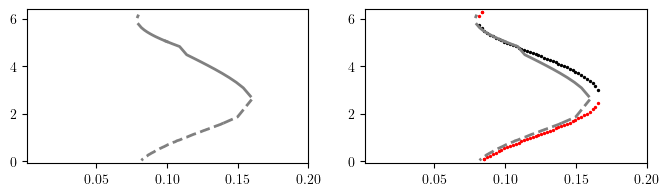

In [126]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys max

In [127]:
# # get min eps
# es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


# eigenvalues_temp = []
# es_max_temp = []
# for i in range(5):
#     ee = es_max-0.0005*i
#     m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
#     eigenvalues_temp.append(m1.eigenvalues)
#     es_max_temp.append(ee)

# b_max_all.append(b)
# eigenvalues_max_all.append(eigenvalues_temp)
# e_vals_mono_max.append(es_max_temp)
# #m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# # m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
# #

# #print(m1.eigenvalues)
# #print(m1b.eigenvalues)

#### Monodromys min

In [128]:
# # get min eps
# es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


# eigenvalues_temp = []
# es_min_temp = []
# for i in range(5):
#     ee = es_min+0.0005*i
#     m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
#     eigenvalues_temp.append(m1.eigenvalues)
#     es_min_temp.append(ee)

# b_min_all.append(b)
# eigenvalues_min_all.append(eigenvalues_temp)
# e_vals_mono_min.append(es_min_temp)
# #m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# # m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
# #

# #print(m1.eigenvalues)
# #print(m1b.eigenvalues)

In [129]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.1

#### Branches eps stable

In [130]:
b=-.1
kw_b['recompute'] = False
kw_b['b'] = b

In [131]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=5,eps_init=0.1,eps_final=0,deps=-.002),
            dict(phi0=5,eps_init=0.099,eps_final=0.2,deps=.005)]

In [132]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 5
phi init 5


In [133]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [134]:
kw_b['recompute'] = False
kw_b['b'] = b

In [135]:
kw_b['b'] = -.08
da,Yinit = follow_phase_diffs_u(**dict(phi0=1,eps_init=0.14,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.085
da,Yinit = follow_phase_diffs_u(**dict(phi0=1,eps_init=0.14,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.085
da,Yinit = follow_phase_diffs_u(**dict(phi0=1,eps_init=0.13,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.09
da,Yinit = follow_phase_diffs_u(**dict(phi0=1,eps_init=0.12,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.095
da,Yinit = follow_phase_diffs_u(**dict(phi0=1,eps_init=0.12,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -.1
da,Yinit = follow_phase_diffs_u(**dict(phi0=1,eps_init=0.12,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 1
phase_diffs_u_init=1_nm=31_b=-0.08_ei=0.14_ef=0_de=-2.txt
phase_diffs_u_pt_init=1_nm=31_b=-0.08_ei=0.14_ef=0_de=-2.txt
[0.14       2.03937184 1.59595782]
phi init 1
phase_diffs_u_init=1_nm=31_b=-0.085_ei=0.14_ef=0_de=-2.txt
phase_diffs_u_pt_init=1_nm=31_b=-0.085_ei=0.14_ef=0_de=-2.txt
[0.14       2.03937184 1.86708579]
phi init 1
phase_diffs_u_init=1_nm=31_b=-0.085_ei=0.13_ef=0_de=-2.txt
phase_diffs_u_pt_init=1_nm=31_b=-0.085_ei=0.13_ef=0_de=-2.txt
[0.13       2.04337192 1.56823385]
phi init 1
phase_diffs_u_init=1_nm=31_b=-0.09_ei=0.12_ef=0_de=-2.txt
phase_diffs_u_pt_init=1_nm=31_b=-0.09_ei=0.12_ef=0_de=-2.txt
[0.12       2.04670531 1.50428052]
phi init 1
phase_diffs_u_init=1_nm=31_b=-0.095_ei=0.12_ef=0_de=-2.txt
phase_diffs_u_pt_init=1_nm=31_b=-0.095_ei=0.12_ef=0_de=-2.txt
[0.12       2.04603863 1.72587984]
phi init 1
phase_diffs_u_init=1_nm=31_b=-0.1_ei=0.12_ef=0_de=-2.txt
phase_diffs_u_pt_init=1_nm=31_b=-0.1_ei=0.12_ef=0_de=-2.txt
[0.12       2.04603863 2.0636855 ]


In [136]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=1,eps_init=0.12,eps_final=0,deps=-.001),
            dict(phi0=1,eps_init=0.1199,eps_final=0.2,deps=.01),
           ]

In [137]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 1
phase_diffs_u_init=1_nm=31_b=-0.1_ei=0.12_ef=0_de=-0.001.txt
phase_diffs_u_pt_init=1_nm=31_b=-0.1_ei=0.12_ef=0_de=-0.001.txt
phi init 1
phase_diffs_u_init=1_nm=31_b=-0.1_ei=0.1199_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=1_nm=31_b=-0.1_ei=0.1199_ef=0.2_de=0.01.txt


In [138]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

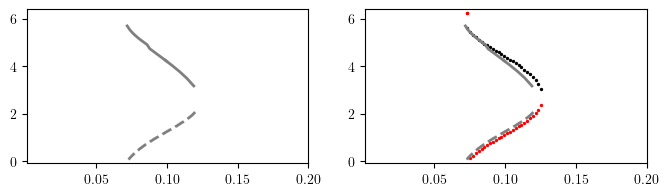

In [139]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [140]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b),max_time=2000)
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.07099999999999995 6.118320386583041
phi init 6.118320386583041
period_est 6.170030850154252 time_est 1996.479982399912
iter, eps phase_diffs 0 0.07099999999999995 [5.80064645]                

data1 shape [[0.071      2.05737218 5.80064645]]
Y [-0.1164833   0.23551528  0.08521584  0.38379143 -0.62608042  0.37893346  0.09116081  0.01204736  6.17317635]
mkdir ./data/thal2_31_b0=-0.1/
* Computing LC data...
self.T 6.1731763451106625e-09                 
loaded coupling expansions
* Computing monodromy (augmented)...
dT: 6.590197927277461e-09
mon eval time 0.9471859931945801
* Floquet Exponent kappa = -0.006246258405054777
es_min,phi0 0.07149999999999995 6.118320386583041
phi init 6.118320386583041
period_est 6.170030850154252 time_est 1995.8699793498968
iter, eps phase_diffs 0 0.07149999999999995 [5.72734941]                

data1 shape [[0.0715     2.05737218 5.72734941]]
Y [-0.11620827  0.21631824  0.08546262  0.40799583 -0.62529793  0.38546907  0.09140634  0.01126516  6.

#### Monodromys max

In [141]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b),max_time=2000)
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.12 6.118320386583041
phi init 6.118320386583041
period_est 6.3000315001575 time_est 1996.8899844499222
iter, eps phase_diffs 0 0.12 [3.08200718]                               

data1 shape [[0.12       2.03870516 3.08200718]]
Y [-3.91229344e-01  7.99059601e-02  9.09427029e-02  2.75241595e-01 -5.76548377e-01  5.28746771e-01  9.10323484e-02  1.65038928e-03  6.11679250e+00]
mkdir ./data/thal2_31_b0=-0.1/
* Loading LC data...
self.T 6.1731763451106625
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.006246258405054777
es_min,phi0 0.1195 6.118320386583041
phi init 6.118320386583041
period_est 6.3000315001575 time_est 1996.8099840499203
iter, eps phase_diffs 0 0.1195 [3.12515528]                             

data1 shape [[0.1195     2.03870516 3.12515528]]
Y [-3.97710950e-01  8.09248852e-02  9.10170818e-02  2.67946857e-01 -5.76998831e-01  5.27862966e-01  9.11242418e-02  1.67749573e-03  6.11656982e+00]
mkdir ./data/thal2_31_b1=-0.1/
* Loading LC d

In [142]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

# Two parameter full

In [143]:
# fname_raw = 'thal2r_{}{}_2par_fixed.dat'
# data = np.loadtxt('../bifdat_2par/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_o2_pos.dat'
data = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_o2_neg.dat'
data2 = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_o2_neg2.dat'
data3 = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

(-0.1, 0.05)

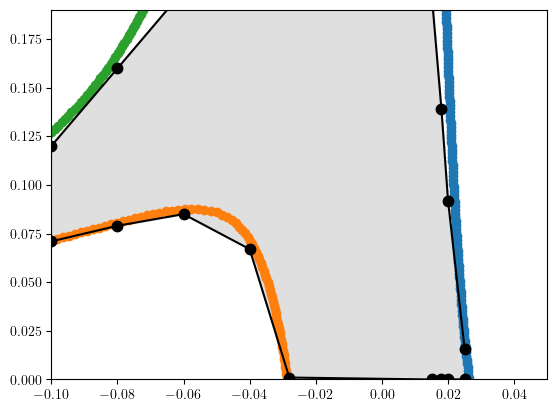

In [144]:
fig,axs = plt.subplots()
axs.fill_between(b_vals_full,e_vals_full,e_hi_full,color='gray',alpha=.25)
axs.plot(b_vals_full,e_vals_full,marker='.',color='k',markersize=15)
axs.plot(b_vals_full,e_hi_full,marker='.',color='k',markersize=15)

# split_idx = np.where(np.isnan(data[:,0]))[0][0]

# br1 = data[:split_idx]
# br2 = data[split_idx+1:]

# axs.plot(br1[:,0],br1[:,1],color='r',marker='.')
# axs.plot(br2[:,0],br2[:,1],color='r',marker='.')

axs.scatter(data[:,1],data[:,0])
axs.scatter(data2[:,1],data2[:,0])
axs.scatter(data3[:,1],data3[:,0])

axs.set_ylim(0,.19)
axs.set_xlim(-.1,.05)

In [145]:
fname_lo = '../v2_bifdat_2par/full/thal2_2par_lo_{}{}.dat'.format(a._n[1],a._m[1])
fname_hi = '../v2_bifdat_2par/full/thal2_2par_hi_{}{}.dat'.format(a._n[1],a._m[1])

arr_lo = np.zeros([len(b_vals_full),2])
arr_hi = np.zeros([len(b_vals_full),2])

arr_lo[:,0] = b_vals_full
arr_lo[:,1] = e_vals_full

arr_hi[:,0] = b_vals_full
arr_hi[:,1] = e_hi_full

np.savetxt(fname_lo,arr_lo)
np.savetxt(fname_hi,arr_hi)

# Eigenvalue Convergence Plot

## Min

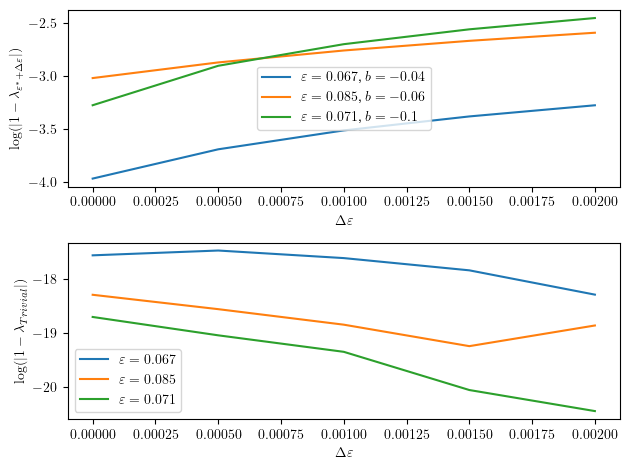

In [146]:
fig,axs = plt.subplots(2,1)

eps_values = np.arange(0,+0.0005*5,.0005)
skipn = 1

for j in range(len(eigenvalues_min_all[::skipn])):
    nn = len(eigenvalues_min_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_min_all[::skipn][j][i])
        
        min1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[min1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    
    ee = e_vals_mono_min[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_min_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*+\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_thal2_min_{}{}.png'.format(a._n[1],a._m[1]))

## Max

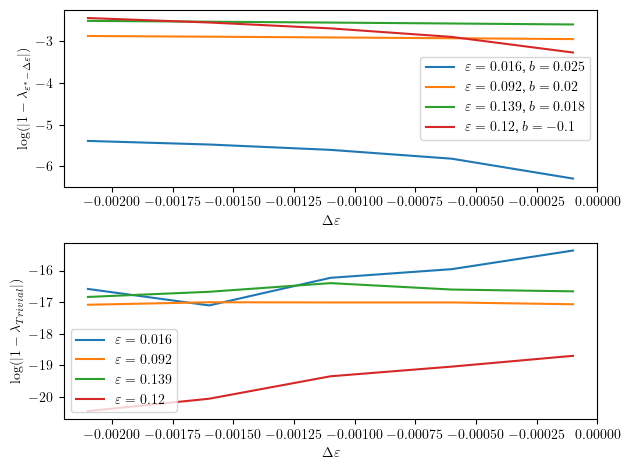

In [148]:
fig,axs = plt.subplots(2,1)

#es_min+.0001+0.0005*i
#ee = es_max-.0001-0.0005*i
eps_values = np.arange(-0.0001,0.0001-0.0005*5,-.0005)
skipn = 1

for j in range(len(eigenvalues_max_all[::skipn])):
    nn = len(eigenvalues_max_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_max_all[::skipn][j][i])
        
        max1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[max1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    ee = e_vals_mono_max[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_max_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*-\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_thal2_max_{}{}.png'.format(a._n[1],a._m[1]))